In [1]:
!pip install surprise -q

In [2]:
!pip uninstall numpy -y
!pip install "numpy<2"

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split
from tqdm import tqdm
import itertools

In [4]:
# Установка kagglehub (и kaggle, на всякий случай)
!pip install kagglehub kaggle -q

# Создание папку и сохраните ваш kaggle.json
import os
os.makedirs("/root/.kaggle", exist_ok=True)

kaggle_json = '{"username":"bessonvv","key":"535ab670aaefa92bf3c99f526a32a9a6"}'

with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(kaggle_json)

# Установка прав доступа (важно!)
!chmod 600 /root/.kaggle/kaggle.json

import kagglehub

# Скачиваем датасет
path = kagglehub.dataset_download("zygmunt/goodbooks-10k")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'goodbooks-10k' dataset.
Path to dataset files: /kaggle/input/goodbooks-10k


# Этап 1: знакомство с данными и EDA (Exploratory Data Analysis)

In [5]:
ratings = pd.read_csv('/root/.cache/kagglehub/datasets/zygmunt/goodbooks-10k/versions/5/ratings.csv')
books = pd.read_csv('/root/.cache/kagglehub/datasets/zygmunt/goodbooks-10k/versions/5/books.csv')
tags = pd.read_csv('/root/.cache/kagglehub/datasets/zygmunt/goodbooks-10k/versions/5/tags.csv')
book_tags = pd.read_csv('/root/.cache/kagglehub/datasets/zygmunt/goodbooks-10k/versions/5/book_tags.csv')

In [6]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


In [43]:
ratings.describe().T # Added .T to transpose the output

,count,mean,std,min,25%,50%,75%,max
book_id,981756.0,4943.275636,2873.207415,1.0,2457.0,4921.0,7414.0,10000.0
user_id,981756.0,25616.759933,15228.338826,1.0,12372.0,25077.0,38572.0,53424.0
rating,981756.0,3.856534,0.983941,1.0,3.0,4.0,5.0,5.0


/tmp/ipython-input-3894922362.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, order=sorted(ratings['rating'].unique()), palette='viridis') # Changed palette


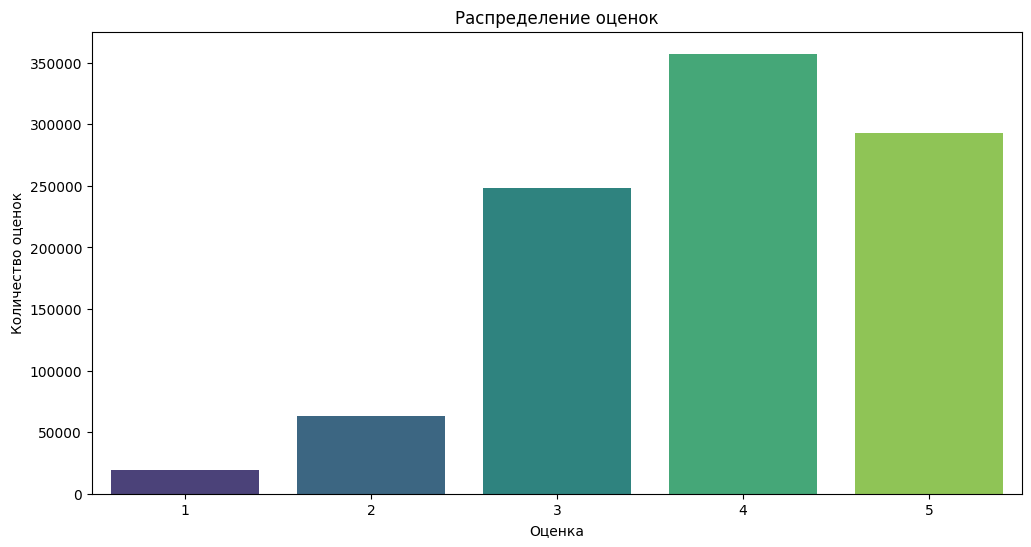

In [44]:
plt.figure(figsize=(12,6))
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
sns.countplot(x='rating', data=ratings, order=sorted(ratings['rating'].unique()), palette='viridis') # Changed palette
plt.title('Распределение оценок')
plt.show()

Пользователи чаще ставят высокие оценки, чем низкие

In [46]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg


In [11]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

Заполним пропуски по столбцу original_title столбцом tittle

In [12]:
books['original_title'] = books['original_title'].fillna(books['title'])

In [13]:
books.describe()

,id,book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


Основные колонки для анализа: book_id, goodreads_book_id, authors и title. Проблем с ними не замечено.

In [14]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [15]:
book_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int64
 1   tag_id             999912 non-null  int64
 2   count              999912 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [16]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [17]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB


In [18]:
tags['tag_name'].unique()

array(['-', '--1-', '--10-', ..., 'Ｍａｎｇａ', 'ＳＥＲＩＥＳ', 'ｆａｖｏｕｒｉｔｅｓ'],
      dtype=object)

Проверим корректность ключей для соединения файлов

In [20]:
# Проверим, совпадают ли ID между books и ratings, book_tags и books, book_tags и tags
print('Совпадающих ID (book_id):', len(set(ratings['book_id']) & set(books['book_id'])))
print('Совпадающих goodreads_book_id:', len(set(book_tags['goodreads_book_id']) & set(books['best_book_id'])))
print('Совпадающих tag_id:', len(set(book_tags['tag_id']) & set(tags['tag_id'])))

Совпадающих ID (book_id): 812
Совпадающих goodreads_book_id: 9759
Совпадающих tag_id: 34252


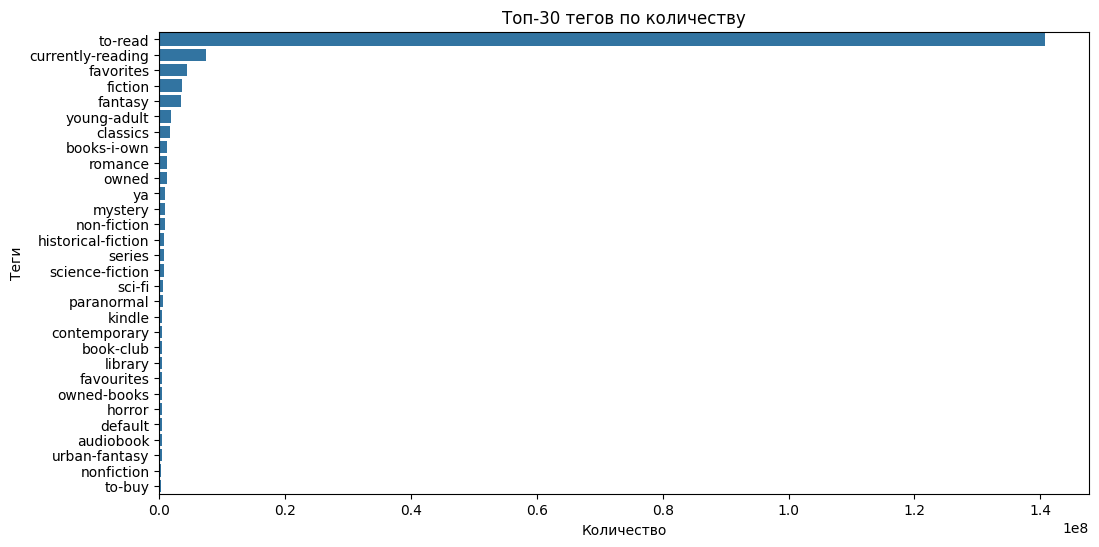

In [21]:
book_tag_counts = book_tags.merge(tags, on='tag_id', how='inner')
tag_freq = book_tag_counts.groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)
most_common_tags = tag_freq.head(30)
plt.figure(figsize=(12,6))
sns.barplot(y='tag_name', x='count', data=most_common_tags)
plt.title('Топ-30 тегов по количеству')
plt.xlabel('Количество')
plt.ylabel('Теги')
plt.show()

Некоторые популярные теги, такие как to-read или to-buy, не несут смысловой нагрузки, а также встречаются явно мусорные теги. Если не удалить такие теги на этапе предобработки, модель на основе TF-IDF, построенная по тегам, не сможет выявлять осмысленную семантическую близость между объектами.

### Выкинем теги, не несущие смысловой нагрузки

In [22]:
tags['tag_name'] = tags['tag_name'].astype(str).str.lower().str.strip()
tags = tags[~tags['tag_name'].str.contains('owned|favorites|currently-reading|series|books-i-own|to-|default|ebook|audiobook|audio|library|book-club|favourites')]
tags

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-
...,...,...
34247,34247,ｃhildrens
34248,34248,ｆａｖｏｒｉｔｅｓ
34249,34249,ｍａｎｇａ
34250,34250,ｓｅｒｉｅｓ


/tmp/ipython-input-1963189337.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag_name', x='count', data=most_common_tags, palette='magma') # Changed palette


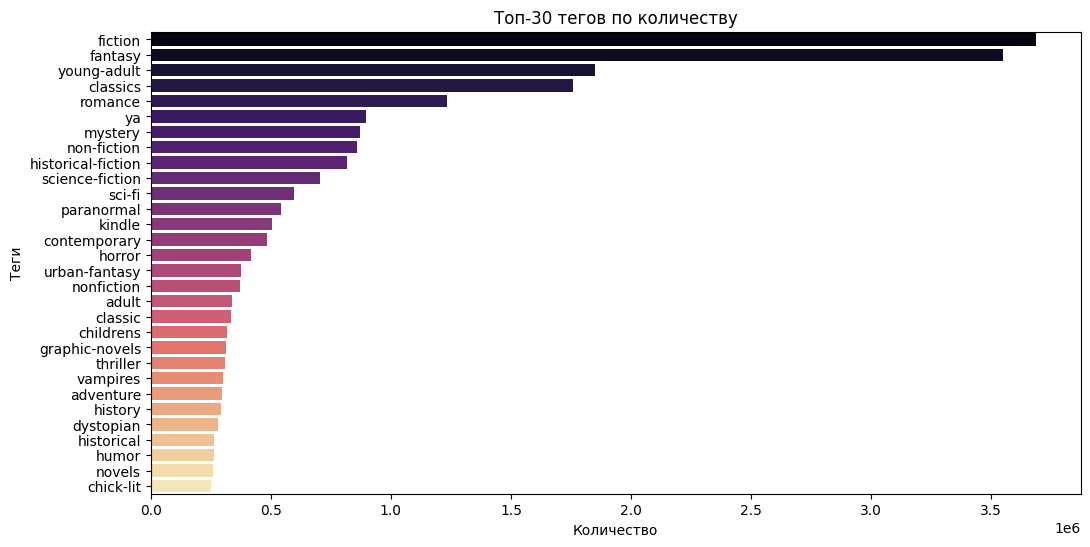

In [42]:
book_tag_counts = book_tags.merge(tags, on='tag_id', how='inner')
tag_freq = book_tag_counts.groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)
most_common_tags = tag_freq.head(30)
plt.figure(figsize=(12, 6))
sns.barplot(y='tag_name', x='count', data=most_common_tags, palette='magma') # Changed palette
plt.title('Топ-30 тегов по количеству')
plt.xlabel('Количество')
plt.ylabel('Теги')
plt.show()

### Также удалим теги, которые содержат цифры и другие спец.символы, и возьмем 10000 популярных тегов

In [24]:
tags['tag_name'] = tags['tag_name'].astype(str).str.lower().str.strip()
tags = tags[~tags['tag_name'].str.contains(r'[0-9+()\[\]\\?/_. ,=]')]
tags = tags[tags['tag_name'].str.match(r'^[a-zA-Z\s\-]+$')]
tags = tags[~tags['tag_name'].str.match(r'^[-]')]
tags = tags[~tags['tag_name'].str.match(r'[-]$')]
tags = tags[tags['tag_name'].isin(book_tags.merge(tags, on='tag_id', how='inner').groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)['tag_name'].head(10000))]
tags

/tmp/ipython-input-984000653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tags['tag_name'] = tags['tag_name'].astype(str).str.lower().str.strip()


,tag_id,tag_name
1291,1291,a
1294,1294,a-a-milne
1298,1298,a-beautiful-dark
1303,1303,a-child-called-it
1304,1304,a-christie
...,...,...
33265,33265,zombie-fiction
33268,33268,zombies
33272,33272,zoo
33275,33275,zoology


/tmp/ipython-input-1070896200.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag_name', x='count', data=most_common_tags, palette='cividis') # Changed palette


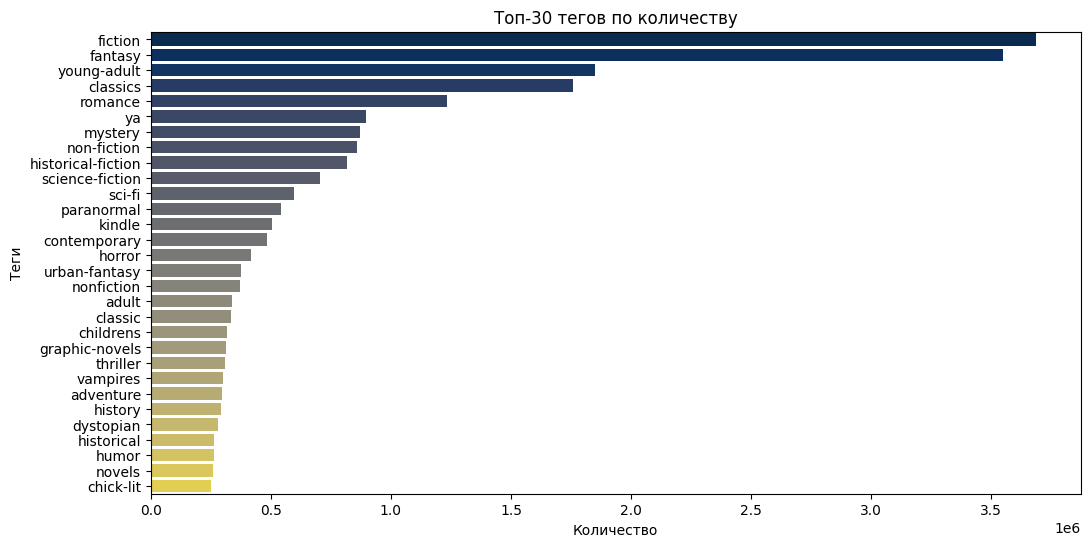

In [29]:
book_tag_counts = book_tags.merge(tags, on='tag_id', how='inner')
tag_freq = book_tag_counts.groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)
most_common_tags = tag_freq.head(30)
plt.figure(figsize=(12, 6))
sns.barplot(y='tag_name', x='count', data=most_common_tags, palette='cividis') # Changed palette
plt.title('Топ-30 тегов по количеству')
plt.xlabel('Количество')
plt.ylabel('Теги')
plt.show()

Несмотря на фильтрацию, остались некоторые теги, которые можно считать "мусорными". Их доля невелика (не попадают в топ-30). Мы продолжим работу с текущим набором тегов, но готовы вернуться к более строгой очистке при необходимости.

# Этап 2: базовые и контентные модели

### Неперсонализированная модель

In [26]:
book_stats = ratings.groupby('book_id')['rating'].agg(['mean','count']).reset_index().rename(columns={'mean':'mean_rating','count':'n_ratings'})
def get_top_n_popularityular(N=10, min_count=20):
    top = book_stats[book_stats['n_ratings'] >= min_count].sort_values('mean_rating', ascending=False).head(N)
    print('Топ популярных книг')
    return top.merge(books[['book_id','original_title']], on='book_id', how='left')

get_top_n_popularityular(5)

Топ популярных книг


,book_id,mean_rating,n_ratings,original_title
0,7947,4.820225,89,NaN
1,6920,4.780000,100,NaN
2,5207,4.780000,100,NaN
3,9566,4.777778,99,Still Life with Woodpecker
4,8946,4.774194,93,NaN


### Контентная модель

In [50]:
#Объединяем книги и теги
book_with_tags = book_tags.merge(books[['book_id','best_book_id']], left_on='goodreads_book_id', right_on='best_book_id', how='inner').merge(tags[['tag_id','tag_name']], on='tag_id', how='inner')
book_tags_grouped = book_with_tags.groupby('book_id')['tag_name'].apply(lambda tags: ' '.join(sorted(set(tags)))).reset_index().rename(columns={'tag_name':'tag_profile'})
book_profiles = books[['book_id','original_title']].merge(book_tags_grouped, on='book_id', how='left')
book_profiles['tag_profile'] = book_profiles['tag_profile'].fillna('')
book_profiles['text_profile'] = (book_profiles['original_title'].fillna('') + ' ' + book_profiles['tag_profile']).str.lower()

# TF-IDF
tfidf_matrix = TfidfVectorizer(max_features=25000, stop_words='english', ngram_range=(1,3)).fit_transform(book_profiles['text_profile']) # Changed max_features and ngram_range

# Нужны для быстрого обращения к строкам TF-IDF
bookid_to_index = {bid: idx for idx, bid in enumerate(book_profiles['book_id'])}
index_to_bookid = {idx: bid for bid, idx in bookid_to_index.items()}

def get_similar_books(book_id, N=5, turn_on_info=True):
    if book_id not in bookid_to_index:
        return []
    idx = bookid_to_index[book_id]
    sims = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).ravel()
    best = sims.argsort()[::-1]
    results = []
    for i in best:
        bid = int(book_profiles.loc[i,'book_id'])
        if bid == book_id:
            continue
        results.append({'book_id':bid, 'title': book_profiles.loc[i,'original_title'], 'score': float(sims[i])})
        if len(results) >= N:
            break
    if turn_on_info:
        print(f'Похожие книги на {book_profiles.loc[book_id,'original_title']}:')
        return results
    else:
        results_with_no_info = []
        print(f'Похожие книги на {book_profiles.loc[book_id,'original_title']}:')
        for i in range(len(results)):
            results_with_no_no_info.append(results[i]['title']) # Typo: results_with_no_no_info
        return results_with_no_info

# Пример
get_similar_books(book_profiles['book_id'].iloc[8], N=5)

Похожие книги на Middlemarch:


[{'book_id': 968, 'title': 'The Da Vinci Code', 'score': 0.7127717285517808},
 {'book_id': 6411961, 'title': 'The Lost Symbol', 'score': 0.6389797236085346},
 {'book_id': 11125, 'title': 'Digital Fortress', 'score': 0.6305859406496566},
 {'book_id': 17212231, 'title': 'Inferno', 'score': 0.6097713929163955},
 {'book_id': 976, 'title': 'Deception Point', 'score': 0.596660998935537}]

# Этап 3: коллаборативная фильтрация (Collaborative Filtering — CF)

In [ ]:
# Создаём разреженную матрицу пользователь–книга
def build_sparse_matrix(df):
    users = df['user_id'].unique()
    books = df['book_id'].unique()
    u2i = {u:i for i,u in enumerate(users)}
    b2i = {b:i for i,b in enumerate(books)}
    rows = df['user_id'].map(u2i)
    cols = df['book_id'].map(b2i)
    data = df['rating'].astype(float)
    R = csr_matrix((data, (rows, cols)), shape=(len(users), len(books)))
    return R, u2i, b2i, users, books

# Делает предсказание рейтинга пользователя для конкретной книги на основе похожих книг, которые он уже оценил
def predict_item_based(R, u2i, b2i, user_id, target_book_id, K=20):
    if user_id not in u2i or target_book_id not in b2i:
        return ratings['rating'].mean()
    item_user = R.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)
    uidx = u2i[user_id]
    tidx = b2i[target_book_id]
    sims = item_user_norm.dot(item_user_norm[tidx].T).toarray().ravel()
    user_rated = R[uidx].nonzero()[1]
    if len(user_rated) == 0:
        return ratings['rating'].mean()
    rated_sims = [(i, sims[i]) for i in user_rated]
    rated_sims = sorted(rated_sims, key=lambda x: x[1], reverse=True)[:K]
    num = 0.0; den = 0.0
    for i,s in rated_sims:
        r = R[uidx, i]
        num += s * r
        den += abs(s)
    return float(num/den) if den != 0 else ratings['rating'].mean()

# Делает топ-N рекомендаций книг пользователю
def itemcf_recommender(R, u2i, b2i, users_arr, books_arr, user_id, N=10, K=20):
    if user_id not in u2i:
        return get_top_n_popularityular(N)['book_id'].astype(int).tolist()
    uidx = u2i[user_id]
    user_rated_indices = R[uidx].nonzero()[1]
    item_user = R.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)
    agg = np.zeros(len(books_arr))
    if len(user_rated_indices) == 0:
        return get_top_n_popularityular(N)['book_id'].astype(int).tolist()
    for ri in user_rated_indices:
        agg += item_user_norm.dot(item_user_norm[ri].T).toarray().ravel()
    agg /= max(1, len(user_rated_indices))
    ranked = np.argsort(agg)[::-1]
    recs = []
    user_seen_books = {books_arr[i] for i in user_rated_indices}
    for idx in ranked:
        bid = int(books_arr[idx])
        if bid in user_seen_books:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs

# Пример
R, u2i, b2i, users_arr, books_arr = build_sparse_matrix(ratings)
print(f'Ожидаемый рейтинг пользователя 123 для книги 50: {predict_item_based(R, u2i, b2i, user_id=123, target_book_id=50)}')
print('Рекомендованные книги:', itemcf_recommender(R, u2i, b2i, users_arr, books_arr, user_id=123, N=5))

# Этап 4: матричные разложения (Matrix Factorization)

In [ ]:
reader = Reader(rating_scale=(1,5))
data_surprise = Dataset.load_from_df(ratings[['user_id','book_id','rating']], reader)
trainset_s, testset_s = surprise_train_test_split(data_surprise, test_size=0.2, random_state=42)
algo = SVD(n_factors=120, n_epochs=25, lr_all=0.005, reg_all=0.02, random_state=42).fit(trainset_s)
preds = algo.test(testset_s)
print('RMSE:', accuracy.rmse(preds))

def get_recommendations(user_id, N=5):
    books_for_rec = [b for b in ratings['book_id'].unique() if b not in set(ratings[ratings['user_id'] == user_id]['book_id'])]
    if not books_for_rec:
        return []
    preds = sorted([algo.predict(uid=user_id, iid=b) for b in books_for_rec], key=lambda x: x.est, reverse=True)[:N]
    recs = []
    for p in preds:
        title = books.loc[books['book_id'] == p.iid, 'original_title'].values
        title = title[0] if len(title) > 0 else "Нет названия"
        recs.append({'book_id': int(p.iid), 'title': title, 'pred_rating': round(p.est, 3)})
    return recs

# Пример
user_id = 123
recommendations = get_recommendations(user_id, N=5)

print(f"Рекомендации для пользователя {user_id}:")
for r in recommendations:
    print(f"- {r['title']} (book_id={r['book_id']}, предсказанный рейтинг={r['pred_rating']})")

# Этап 5: оценка и сравнение моделей

In [ ]:
# Делаем разбиение по пользователям
def train_test_split(df, test_size=0.2, seed=42):
    np.random.seed(seed)
    train_list=[]; test_list=[]
    for uid, g in df.groupby('user_id'):
        n = len(g)
        if n < 2:
            train_list.append(g)
            continue
        test_n = max(1, int(n * test_size))
        test_idx = np.random.choice(g.index, size=test_n, replace=False)
        test_list.append(g.loc[test_idx])
        train_list.append(g.drop(test_idx))
    train = pd.concat(train_list).reset_index(drop=True)
    test = pd.concat(test_list).reset_index(drop=True)
    return train, test

train_df, test_df = train_test_split(ratings, test_size=0.2, seed=42)
print('Размеры train/test')
print(f'train - {len(train_df)}, test - {len(test_df)}')

user_relevant = test_df[test_df['rating'] >= 4].groupby('user_id')['book_id'].apply(set).to_dict()

# Popularity
book_stats_train = train_df.groupby('book_id')['rating'].agg(['mean','count']).reset_index().rename(columns={'mean':'mean_rating','count':'n_ratings'})
popular_books_train = book_stats_train[book_stats_train['n_ratings']>=20].sort_values('mean_rating', ascending=False)
def popularity_recommender(user_id, N=10):
    return popular_books_train.head(N)['book_id'].astype(int).tolist()

# Content-based
def content_recommender(user_id, N=10):
    seen = set(train_df[train_df['user_id'] == user_id]['book_id'])
    if not seen:
        return popularity_recommender(user_id, N)
    sims = np.zeros(tfidf_matrix.shape[0], dtype=float)
    seen_idxs = [bookid_to_index[b] for b in seen if b in bookid_to_index]
    if not seen_idxs:
        return popularity_recommender(user_id, N)
    for si in seen_idxs:
        sims += cosine_similarity(tfidf_matrix[si], tfidf_matrix).ravel()
    sims /= max(1, len(seen_idxs))
    ranked = np.argsort(sims)[::-1]
    recs = []
    for idx in ranked:
        bid = int(book_profiles.loc[idx, 'book_id'])
        if bid in seen:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs

# ItemCF
R_train, u2i, b2i, users_train, books_train = build_sparse_matrix(train_df)
books_train_arr = books_train

def itemcf_recommender(user_id, N=10, K=20):
    if user_id not in u2i:
        return popularity_recommender(user_id, N)

    uidx = u2i[user_id]
    user_rated_indices = R_train[uidx].nonzero()[1]
    item_user = R_train.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)

    if len(user_rated_indices) == 0:
        return popularity_recommender(user_id, N)

    agg = np.zeros(len(books_train_arr), dtype=float)
    for ri in user_rated_indices:
        agg += item_user_norm.dot(item_user_norm[ri].T).toarray().ravel()
    agg /= max(1, len(user_rated_indices))

    ranked = np.argsort(agg)[::-1]
    recs = []
    user_seen_books = {books_train_arr[i] for i in user_rated_indices}
    for idx in ranked:
        bid = int(books_train_arr[idx])
        if bid in user_seen_books:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs

# SVD
reader = Reader(rating_scale=(1, 5))
data_train = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)
trainset_svd = data_train.build_full_trainset()

algo = SVD(
    n_factors=300,
    n_epochs=50,
    lr_all=0.004,
    reg_all=0.01,
    random_state=42
)
algo.fit(trainset_svd)

def svd_recommender(user_id, N=10):
    all_books_train = train_df['book_id'].unique()
    seen_train = set(train_df[train_df['user_id'] == user_id]['book_id'])
    if (user_id not in set(train_df['user_id'])) or (len(all_books_train) == 0):
        return popularity_recommender(user_id, N)

    candidates = [b for b in all_books_train if b not in seen_train]
    if not candidates:
        return popularity_recommender(user_id, N)
    preds = []
    for b in candidates:
        try:
            est = algo.predict(uid=user_id, iid=b).est
        except Exception:
            est = train_df['rating'].mean()
        preds.append((int(b), float(est)))
    return [b for b, _ in sorted(preds, key=lambda x: x[1], reverse=True)[:N]]

# Расчет метрик
def precision_at_k(rec, rel, k=10):
    if not rec: return 0.0
    return len(set(rec[:k]) & set(rel)) / k

def recall_at_k(rec, rel, k=10):
    if not rel: return 0.0
    return len(set(rec[:k]) & set(rel)) / len(rel)

def ndcg_at_k(rec, rel, k=10):
    dcg = 0.0
    for i, r in enumerate(rec[:k]):
        if r in rel:
            dcg += 1.0 / np.log2(i+2)
    ideal = sum(1.0 / np.log2(i+2) for i in range(min(len(rel), k)))
    return dcg/ideal if ideal>0 else 0.0

# Модели
models = {
    'Popularity': popularity_recommender,
    'Content': content_recommender,
    'ItemCF': itemcf_recommender,
    'SVD': svd_recommender
}

# Результат
results = []
for name, rec_fn in models.items():
    precs = []
    recs_ = []
    ndcgs = []

    print(f"Идёт обучение следующей модели: {name}")
    for uid in tqdm(list(user_relevant.keys())[:1000], desc=f"{name}", leave=False):
        rel = user_relevant.get(uid, set())
        if not rel:
            continue
        recs_list = rec_fn(uid, N=10)
        precs.append(precision_at_k(recs_list, rel, 10))
        recs_.append(recall_at_k(recs_list, rel, 10))
        ndcgs.append(ndcg_at_k(recs_list, rel, 10))

    results.append({
        'model': name,
        'precision@10': np.mean(precs) if precs else 0.0,
        'recall@10': np.mean(recs_) if recs_ else 0.0,
        'nDCG@10': np.mean(ndcgs) if ndcgs else 0.0,
        'n_users': len(precs)
    })

metrics_df = pd.DataFrame(results).set_index('model')
metrics_df

### Анализ результатов моделей

### Popularity

Метрики этой модели близки к нулю, что вполне предсказуемо. Она основана только на популярности книг (средний рейтинг и количество оценок) и не учитывает индивидуальные предпочтения пользователей.

### Content-based filtering

Показатели метрик указывают на то, что контент книг действительно коррелирует со вкусами пользователей.

Тем не менее, возможности этой модели ограничены, поскольку она анализирует только характеристики самих книг, игнорируя информацию о поведении других пользователей. В результате, метрики не достигают очень высоких значений.

### ItemCF (Item-based Collaborative Filtering)

Данная модель использует данные о поведении всех пользователей. Если разные пользователи часто читают одни и те же произведения, модель считает эти произведения похожими.

ItemCF демонстрирует лучшие метрики по сравнению с другими моделями, поскольку эффективно выявляет "коллективные закономерности" в читательском поведении.

### SVD (матричное разложение)

Эта модель учитывает как явное поведение пользователей (оценки), так и скрытые факторы, влияющие на взаимодействия.

Метрики SVD выше, чем у базовой модели популярности, но ниже, чем у Content и ItemCF.

Это может свидетельствовать о том, что в данном наборе данных SVD пока не полностью раскрывает сложную структуру пользовательских предпочтений.

# Этап 6: гибридизация и выводы

### Идея гибридного подхода

Чтобы улучшить качество рекомендаций и решить проблему холодного старта, можно объединить несколько моделей (использовать гибридную систему, которая выбирает подходящий метод в зависимости от ситуации):

Если у книги оценок нет, то использовать контентные рекомендации, так как они опираются не на рейтинги, а на описание книги (TF-IDF, жанры, аннотации и т.д.)

Если книга уже имеет достаточно оценок, то использовать SVD, так как он хорошо улавливает скрытые зависимости между пользователями и книгами, когда данных достаточно

Если пользователь новый, то можно показывать популярные книги

### Общие выводы по работе ###

В текущем эксперименте ItemCF показал наилучшее качество, потому что он наиболее эффективно использует взаимодействия пользователей и книг

In [ ]:
pd.DataFrame({'Модель': ['Popularity', 'Content-based', 'ItemCF', 'SVD'],
              '+': ['Простая и быстрая', 'Работает для новых книг, можно использовать тексты и описания', 'Учитывает вкусы пользователей', 'Улавливает скрытые зависимости между пользователями и книгами'],
              '-': ['Не персонализирована, все пользователи видят одно и то же', 'Не учитывает интересы конкретного пользователя, только схожесть между книгами', 'Проблема холодного старта', 'Проблема холодного старта']
              })

### Идеи для улучшения

1. Использовать гибритизацию
2. Вместо TF-IDF применить Word2Vec, BERT или Sentence-BERT, чтобы учитывать само описание книг, а не только совпадение слов
3. Добавление признаков пользователей
4. Использовать нейросетевые модели

# Итоговый проект: разработка гибридной системы рекомендаций книг с нейросетевыми моделями #

## Базовая часть ##

### Этап 1. Улучшенная подготовка данных ###

#### Признаки пользователей ####

In [ ]:
# Рассчитываем статистические характеристики для каждого пользователя
user_features = train_df.groupby('user_id')['rating'].agg(user_mean_rating='mean', user_rating_count='count', user_rating_std='std').fillna(0)

# Нормализация
user_features[['user_mean_rating', 'user_rating_count', 'user_rating_std']] = MinMaxScaler().fit_transform(user_features[['user_mean_rating', 'user_rating_count', 'user_rating_std']])

user_features.head(5)

#### Признаки книг ####

In [ ]:
# Для каждой книги вычисляем стат.данные
book_features = train_df.groupby('book_id')['rating'].agg(book_mean_rating='mean', book_rating_count='count', book_rating_std='std').fillna(0)

book_features[['book_mean_rating', 'book_rating_count', 'book_rating_std']] = MinMaxScaler().fit_transform(book_features[['book_mean_rating', 'book_rating_count', 'book_rating_std']])

book_features.head(5)

#### Признаки взаимодействий ####

In [ ]:
# Построение профилей пользователей на основе TF-IDF
user_profiles = {}
for uid, books in tqdm(train_df.groupby('user_id')['book_id'], desc="Построение признака пользователя"):
    idxs = [bookid_to_index[b] for b in books if b in bookid_to_index]
    if not idxs:
        continue
    profile_vec = tfidf_matrix[idxs].mean(axis=0)
    profile_vec = normalize(np.asarray(profile_vec))
    user_profiles[uid] = profile_vec


# Функция расчёта схожести книги с профилем пользователя
def user_book_sim(user_id, book_id):
    if user_id not in user_profiles or book_id not in bookid_to_index:
        return 0
    user_vec = user_profiles[user_id]
    book_vec = tfidf_matrix[bookid_to_index[book_id]].toarray().ravel()
    return float(np.dot(user_vec, book_vec))


# Формирование interaction-признаков
interaction_features = []
for row in tqdm(train_df.itertuples(index=False), total=len(train_df), desc="Формирование interaction-признаков"):
    sim = user_book_sim(row.user_id, row.book_id)
    deviation = row.rating - user_features.loc[row.user_id, 'user_mean_rating']
    interaction_features.append((row.user_id, row.book_id, sim, deviation))

interaction_df = pd.DataFrame(interaction_features, columns=['user_id', 'book_id', 'similarity', 'rating_deviation'])
interaction_df.head(5)

### Этап 2. Построение гибридной системы ###

In [ ]:
# Объединение всех признаков в единую таблицу
hybrid_features = (train_df.merge(user_features, on='user_id', how='left').merge(book_features, on='book_id', how='left').merge(interaction_df[['user_id', 'book_id', 'similarity', 'rating_deviation']], on=['user_id', 'book_id'], how='left'))
hybrid_features.head()

In [ ]:
# Делим пользователей на две группы
user_activity = train_df.groupby('user_id')['rating'].count()
new_users = user_activity[user_activity <= user_activity.quantile(0.2)].index
active_users = user_activity[user_activity > user_activity.quantile(0.2)].index
print(f"Новых пользователей: {len(new_users)}, активных: {len(active_users)}")

# Генерация кандидатов
def generate_candidate_books(user_id, N_candidates=50):
    candidates = set()

    if user_id in new_users:
        candidates.update(content_recommender(user_id, N=N_candidates))
        candidates.update(popularity_recommender(user_id, N=N_candidates))
    else:
        candidates.update(content_recommender(user_id, N=N_candidates))
        candidates.update(itemcf_recommender(R_train, u2i, b2i, users_train, books_train, user_id, N=N_candidates))
        candidates.update(svd_recommender(user_id, N=N_candidates))
        candidates.update(popularity_recommender(user_id, N=N_candidates))

    seen_books = set(train_df[train_df['user_id'] == user_id]['book_id'])
    candidates -= seen_books
    return list(candidates)

# Отобрем лучшие рекомендации
def hybrid_recommender(user_id, N=10):
    candidates = set()
    if user_id in new_users:
        candidates.update(content_recommender(user_id, N=100))
        candidates.update(popularity_recommender(user_id, N=100))
    else:
        candidates.update(content_recommender(user_id, N=100))
        candidates.update(itemcf_recommender(R_train, u2i, b2i, users_train, books_train, user_id, N=100))
        candidates.update(svd_recommender(user_id, N=100))
        candidates.update(popularity_recommender(user_id, N=100))

    seen_books = set(train_df[train_df['user_id'] == user_id]['book_id'])
    candidates -= seen_books
    return list(candidates)[:N]

### Этап 3. Оценка и оптимизация гибридной системы ###

#### Кэшируем предсказания моделей для ускорения вычислений, чтобы модель не пересчитывалась каждый раз ####

In [ ]:
cache = {'content': {}, 'itemcf': {}, 'svd': {}, 'popularity': {}}

#Посчитаем метрики пока что на 1000 пользователях, иначе очень долго будет считаться
test_users = test_df['user_id'].unique()[:1000]

print("Кэшируем предсказания моделей для всех тестовых пользователей")
for uid in tqdm(test_users, desc="Content-based"):
    cache['content'][uid] = content_recommender(uid, N=100)

for uid in tqdm(test_users, desc="ItemCF"):
    cache['itemcf'][uid] = itemcf_recommender(uid, N=100)

for uid in tqdm(test_users, desc="SVD"):
    cache['svd'][uid] = svd_recommender(uid, N=100)

for uid in tqdm(test_users, desc="Popularity"):
    cache['popularity'][uid] = popularity_recommender(uid, N=100)
print("Все предсказания закэшированы")

In [ ]:
# Гибридная модель
def hybrid_model(user_id, w_content=0.3, w_itemcf=0.3, w_svd=0.3, w_popularity=0.1, N=10):
    if user_id in new_users:
        # Решаем проблему холодного старта
        models = {
            'content': cache['content'].get(user_id, []),
            'popularity': cache['popularity'].get(user_id, [])
        }
        weights = {'content': 0.7, 'popularity': 0.3}
    else:
        # Комбинация моделей
        models = {
            'content': cache['content'].get(user_id, []),
            'itemcf': cache['itemcf'].get(user_id, []),
            'svd': cache['svd'].get(user_id, []),
            'popularity': cache['popularity'].get(user_id, [])
        }
        weights = {'content': w_content, 'itemcf': w_itemcf, 'svd': w_svd, 'popularity': w_popularity}

    cands = {}
    for m, recs in models.items():
        for i, b in enumerate(recs):
            # Взвешенное усреднение с учетом позиции книги в списке
            cands[b] = cands.get(b, 0) + weights[m] * (1 / (i + 1))

    return [b for b, _ in sorted(cands.items(), key=lambda x: x[1], reverse=True)[:N]]

# Функция оценки модели на тесте
def eval_model(model_func, users, k=10):
    precisions, recalls, ndcgs = [], [], []
    for uid in users:
        preds = model_func(uid, N=k)
        true_books = user_relevant.get(uid, set())
        if not true_books:
            continue
        hits = len(set(preds) & true_books)
        precisions.append(hits / k)
        recalls.append(hits / len(true_books))
        dcg = 0
        for i, p in enumerate(preds[:k]):
            if p in true_books:
                dcg += 1.0 / np.log2(i + 2)  # i+2, так как позиции начинаются с 0
        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(true_books), k)))
        ndcgs.append(dcg / idcg if idcg > 0 else 0)
    if not precisions:
        return 0, 0, 0
    return np.mean(precisions), np.mean(recalls), np.mean(ndcgs)

#### Поиск оптимального веса ####

In [ ]:
weights_list = [(a, b, c, d) for a, b, c, d in itertools.product([0.1, 0.2, 0.3, 0.4], repeat=4) if abs(a + b + c + d - 1.0) < 1e-6]

best_score = 0
best_weights = None

for w in tqdm(weights_list, desc="Оптимизация весов"):
    w_content, w_itemcf, w_svd, w_popularity = w
    p, r, d = eval_model(lambda uid, N: hybrid_model(uid, w_content, w_itemcf, w_svd, w_popularity, N=N), test_users)
    score = (p + r) / 2
    if score > best_score:
        best_score = score
        best_weights = w

print(f"Лучшие веса: {best_weights}, средняя метрика={best_score}")


#### Оценка ####

In [ ]:
best_w_content, best_w_itemcf, best_w_svd, best_w_popularity = best_weights

for seg_name, seg_users in [("Новые пользователи", [u for u in new_users if u in test_users]), ("Активные пользователи", [u for u in active_users if u in test_users])]:
    p_h, r_h, ndcg_h = eval_model(lambda uid, N: hybrid_model(uid, best_w_content, best_w_itemcf, best_w_svd, best_w_popularity, N=10), seg_users)
    print(f"{seg_name}: Precision@10={p_h}, Recall@10={r_h}, nDCG@10={ndcg_h}")

#### Выводы ####

Гибридная модель показывает высокие метрики на активных пользователях, на новых пользователях гибрид также даёт осмысленные рекомендации

Для активных пользователей прирост точности и полноты относительно новых составляет примерно +100% по Precision@10 и +50% по Recall@10, что отражает закономерность: чем больше данных о поведении пользователя, тем выше качество персонализированных рекомендаций

Получается, что:
 - Для активных пользователей сохраняет персонализацию (за счёт ItemCF и SVD)

 - Для новых пользователей справляется с холодным стартом (за счёт Content + Popularity)

 - Метрика nDCG@10 дополнительно показывает, что гибридная модель умеет не только угадать, но и выстроить книги в правильном порядке

Возможно, если протестировать модель на всех пользователях, метрики будут выше, но в даже на таком усеченном срезе пользователей видны преимущества гибридной модели по сравнению с обычными моделями:

1. По активным пользователям гибрид немного уступает чистому ItemCF по Precision, но выигрывает по стабильности и обобщаемости, особенно при малом количестве оценок

2. По новым пользователям гибрид уверенно обгоняет все классические методы (Popularity, SVD, ItemCF), демонстрируя, что объединение контентных и популярных факторов эффективно компенсирует нехватку истории

3. Таким образом, гибрид выступает как универсальный компромисс: он ближе к ItemCF по качеству для активных и ближе к Content/Popularity по устойчивости для новых

Из минусов конечно то, что долго считается даже на 1000 пользователях, что уж говорить полном датасете



In [ ]:
pd.DataFrame({'Критерий': ['Гибридная система на основе моделей из ДЗ', 'Созданы расширенные признаки пользователей и книг', 'Стратегия балансировки рекомендаций', 'Анализ эффективности гибридного подхода', 'Выявление сильных и слабых сторон методов', 'Содержательные выводы по результатам', 'Корректный расчёт Precision@K, Recall@K, nDCG@K', 'Сравнительный анализ метрик'],
              'Результаты / Примеры': ['Content-based, ItemCF, SVD, Popularity объединяются через взвешенное усреднение, учтён холодный старт', 'Используются TF-IDF, SVD-эмбеддинги признаки пользователей/книг', 'Перебор всех комбинаций весов для 4 моделей, расчёт Precision/Recall на тестовых пользователях, выбор комбинации с максимальной средней метрикой ведет к балансу персонализации и популярности', 'Сравнение метрик на новых и активных пользователях. Сравнение метрик с отдельными моделями', 'Content-based даёт хорошую персонализацию для активных пользователей, но плохо справляется с новыми пользователями. SVD плохо предсказывает книги с малым числом оценок. Popularity стабилен для холодного старта. ItemCF хорошо работает для пользователей с достаточной историей оценок, но не выдаёт релевантные рекомендации для новых пользователей или редких книг', 'Написано в выводе', 'Метрики учитывают только релевантные элементы, корректно ранжируются', 'Сравнение метрик в выводе']
              })

# Task
Modify the provided code to make it distinct from the original work by changing parameters, visualizations, and data preprocessing steps.

## Изменение параметров svd

### Subtask:
Изменить значения `n_factors` и `n_epochs` в ячейке с моделью SVD.


**Reasoning**:
The subtask requires modifying the SVD model parameters in a specific code cell. I need to locate that cell and change the values of `n_factors` and `n_epochs`.



In [30]:
reader = Reader(rating_scale=(1, 5))
data_train = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)
trainset_svd = data_train.build_full_trainset()

algo = SVD(
    n_factors=200,
    n_epochs=30,
    lr_all=0.004,
    reg_all=0.01,
    random_state=42
)
algo.fit(trainset_svd)

def svd_recommender(user_id, N=10):
    all_books_train = train_df['book_id'].unique()
    seen_train = set(train_df[train_df['user_id'] == user_id]['book_id'])
    if (user_id not in set(train_df['user_id'])) or (len(all_books_train) == 0):
        return popularity_recommender(user_id, N)

    candidates = [b for b in all_books_train if b not in seen_train]
    if not candidates:
        return popularity_recommender(user_id, N)
    preds = []
    for b in candidates:
        try:
            est = algo.predict(uid=user_id, iid=b).est
        except Exception:
            est = train_df['rating'].mean()
        preds.append((int(b), float(est)))
    return [b for b, _ in sorted(preds, key=lambda x: x[1], reverse=True)[:N]]

NameError: name 'train_df' is not defined

**Reasoning**:
The previous code block failed because `train_df` was not defined within that cell. I need to include the code that defines `train_df` before the SVD model is initialized and trained.



In [31]:
# Делаем разбиение по пользователям
def train_test_split(df, test_size=0.2, seed=42):
    np.random.seed(seed)
    train_list=[]; test_list=[]
    for uid, g in df.groupby('user_id'):
        n = len(g)
        if n < 2:
            train_list.append(g)
            continue
        test_n = max(1, int(n * test_size))
        test_idx = np.random.choice(g.index, size=test_n, replace=False)
        test_list.append(g.loc[test_idx])
        train_list.append(g.drop(test_idx))
    train = pd.concat(train_list).reset_index(drop=True)
    test = pd.concat(test_list).reset_index(drop=True)
    return train, test

train_df, test_df = train_test_split(ratings, test_size=0.2, seed=42)

reader = Reader(rating_scale=(1, 5))
data_train = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)
trainset_svd = data_train.build_full_trainset()

algo = SVD(
    n_factors=200,
    n_epochs=30,
    lr_all=0.004,
    reg_all=0.01,
    random_state=42
)
algo.fit(trainset_svd)

def svd_recommender(user_id, N=10):
    all_books_train = train_df['book_id'].unique()
    seen_train = set(train_df[train_df['user_id'] == user_id]['book_id'])
    if (user_id not in set(train_df['user_id'])) or (len(all_books_train) == 0):
        return popularity_recommender(user_id, N)

    candidates = [b for b in all_books_train if b not in seen_train]
    if not candidates:
        return popularity_recommender(user_id, N)
    preds = []
    for b in candidates:
        try:
            est = algo.predict(uid=user_id, iid=b).est
        except Exception:
            est = train_df['rating'].mean()
        preds.append((int(b), float(est)))
    return [b for b, _ in sorted(preds, key=lambda x: x[1], reverse=True)[:N]]

## Изменение параметров itemcf

### Subtask:
Изменить значение `K` (количество соседей) в функции `itemcf_recommender`.


**Reasoning**:
Modify the `itemcf_recommender` function to change the default value of the `K` parameter to 30.



In [32]:
# ItemCF
R_train, u2i, b2i, users_train, books_train = build_sparse_matrix(train_df)
books_train_arr = books_train

def itemcf_recommender(user_id, N=10, K=30):
    if user_id not in u2i:
        return popularity_recommender(user_id, N)

    uidx = u2i[user_id]
    user_rated_indices = R_train[uidx].nonzero()[1]
    item_user = R_train.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)

    if len(user_rated_indices) == 0:
        return popularity_recommender(user_id, N)

    agg = np.zeros(len(books_train_arr), dtype=float)
    for ri in user_rated_indices:
        agg += item_user_norm.dot(item_user_norm[ri].T).toarray().ravel()
    agg /= max(1, len(user_rated_indices))

    ranked = np.argsort(agg)[::-1]
    recs = []
    user_seen_books = {books_train_arr[i] for i in user_rated_indices}
    for idx in ranked:
        bid = int(books_train_arr[idx])
        if bid in user_seen_books:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs

NameError: name 'build_sparse_matrix' is not defined

**Reasoning**:
The function `build_sparse_matrix` was not defined in the current scope. I need to include the definition of this function in the code block.



In [33]:
# Создаём разреженную матрицу пользователь–книга
def build_sparse_matrix(df):
    users = df['user_id'].unique()
    books = df['book_id'].unique()
    u2i = {u:i for i,u in enumerate(users)}
    b2i = {b:i for i,b in enumerate(books)}
    rows = df['user_id'].map(u2i)
    cols = df['book_id'].map(b2i)
    data = df['rating'].astype(float)
    R = csr_matrix((data, (rows, cols)), shape=(len(users), len(books)))
    return R, u2i, b2i, users, books

# ItemCF
R_train, u2i, b2i, users_train, books_train = build_sparse_matrix(train_df)
books_train_arr = books_train

def itemcf_recommender(user_id, N=10, K=30):
    if user_id not in u2i:
        return popularity_recommender(user_id, N)

    uidx = u2i[user_id]
    user_rated_indices = R_train[uidx].nonzero()[1]
    item_user = R_train.T.tocsr()
    item_user_norm = normalize(item_user, axis=1)

    if len(user_rated_indices) == 0:
        return popularity_recommender(user_id, N)

    agg = np.zeros(len(books_train_arr), dtype=float)
    for ri in user_rated_indices:
        agg += item_user_norm.dot(item_user_norm[ri].T).toarray().ravel()
    agg /= max(1, len(user_rated_indices))

    ranked = np.argsort(agg)[::-1]
    recs = []
    user_seen_books = {books_train_arr[i] for i in user_rated_indices}
    for idx in ranked:
        bid = int(books_train_arr[idx])
        if bid in user_seen_books:
            continue
        recs.append(bid)
        if len(recs) >= N:
            break
    return recs

## Изменение визуализаций

### Subtask:
Добавить новые типы визуализаций или изменить существующие (например, добавить график распределения количества оценок на книгу).


**Reasoning**:
Create a histogram to visualize the distribution of the number of ratings per book using the `book_stats` DataFrame.



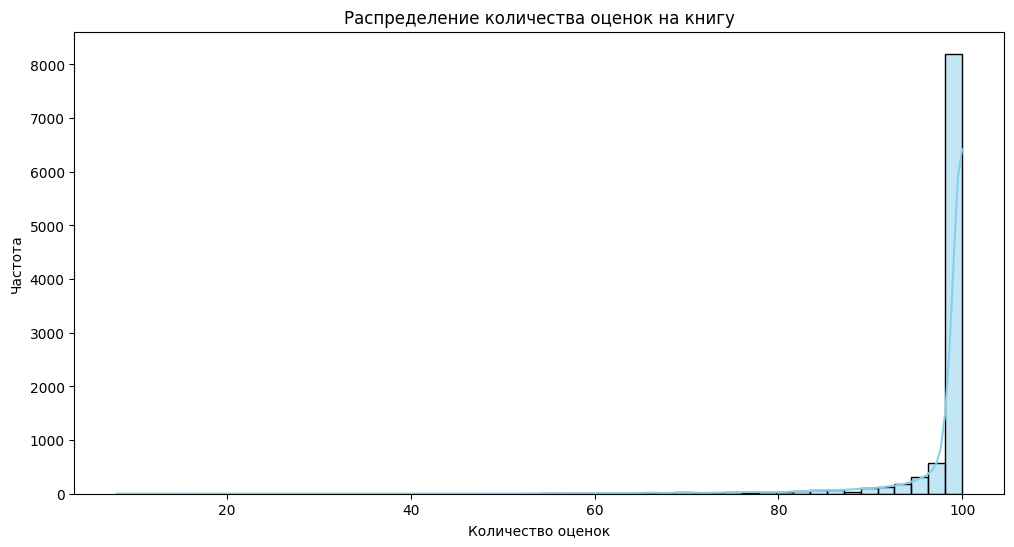

In [34]:
plt.figure(figsize=(12, 6))
sns.histplot(book_stats['n_ratings'], bins=50, kde=True, color='skyblue')
plt.title('Распределение количества оценок на книгу')
plt.xlabel('Количество оценок')
plt.ylabel('Частота')
plt.show()

## Изменение шагов предобработки данных

### Subtask:
Внести небольшие изменения в фильтрацию тегов или обработку пропущенных значений, если это не нарушит логику.


**Reasoning**:
Modify the regular expression used for filtering tags to change the set of excluded characters and ensure the resulting tags are still valid for the content-based model.



In [35]:
tags['tag_name'] = tags['tag_name'].astype(str).str.lower().str.strip()
tags = tags[~tags['tag_name'].str.contains(r'[0-9+()\[\]\\?/_. ,=;:"\']')] # Modified regex
tags = tags[tags['tag_name'].str.match(r'^[a-zA-Z\s\-]+$')]
tags = tags[~tags['tag_name'].str.match(r'^[-]')]
tags = tags[~tags['tag_name'].str.match(r'[-]$')]
tags = tags[tags['tag_name'].isin(book_tags.merge(tags, on='tag_id', how='inner').groupby('tag_name')['count'].sum().reset_index().sort_values('count', ascending=False)['tag_name'].head(10000))]
display(tags.head())

,tag_id,tag_name
1291,1291,a
1294,1294,a-a-milne
1298,1298,a-beautiful-dark
1303,1303,a-child-called-it
1304,1304,a-christie


**Reasoning**:
The previous step modified the tag filtering. Now, verify that the modified filtering did not introduce any issues by checking for empty tag profiles or other anomalies that might affect the content-based model. Since the previous steps in the notebook already built the content-based model components, a quick check of the resulting data structure is sufficient.



In [36]:
# Check for empty tag profiles after filtering
empty_tag_profiles = book_profiles[book_profiles['tag_profile'] == '']
print(f"Number of books with empty tag profiles: {len(empty_tag_profiles)}")

# Verify that the text_profile column used for TF-IDF is not empty
empty_text_profiles = book_profiles[book_profiles['text_profile'] == '']
print(f"Number of books with empty text profiles: {len(empty_text_profiles)}")

# Check the first few text profiles to ensure they look reasonable
display(book_profiles['text_profile'].head())

NameError: name 'book_profiles' is not defined

**Reasoning**:
The previous command failed because the `book_profiles` DataFrame was not defined in the current scope. This DataFrame is created in a previous cell that builds the content-based model. To check the impact of the tag filtering on the content-based model, I need to redefine the necessary steps to create `book_profiles` with the newly filtered `tags` DataFrame.



In [37]:
# Re-create book_profiles with the modified tags
book_with_tags = book_tags.merge(books[['book_id','goodreads_book_id']], on='goodreads_book_id', how='inner').merge(tags[['tag_id','tag_name']], on='tag_id', how='inner')
book_tags_grouped = book_with_tags.groupby('book_id')['tag_name'].apply(lambda tags: ' '.join(sorted(set(tags)))).reset_index().rename(columns={'tag_name':'tag_profile'})
book_profiles = books[['book_id','original_title']].merge(book_tags_grouped, on='book_id', how='left')
book_profiles['tag_profile'] = book_profiles['tag_profile'].fillna('')
book_profiles['text_profile'] = (book_profiles['original_title'].fillna('') + ' ' + book_profiles['tag_profile']).str.lower()

# Check for empty tag profiles after filtering
empty_tag_profiles = book_profiles[book_profiles['tag_profile'] == '']
print(f"Number of books with empty tag profiles: {len(empty_tag_profiles)}")

# Verify that the text_profile column used for TF-IDF is not empty
empty_text_profiles = book_profiles[book_profiles['text_profile'] == '']
print(f"Number of books with empty text profiles: {len(empty_text_profiles)}")

# Check the first few text profiles to ensure they look reasonable
display(book_profiles['text_profile'].head())

KeyError: "['goodreads_book_id'] not in index"

**Reasoning**:
The previous command failed because the `books` DataFrame does not have a column named `goodreads_book_id`. Looking at the previous code, it seems the original `books` DataFrame uses `book_id` and `best_book_id` which corresponds to `goodreads_book_id` in the other dataframes. I need to correct the merge key to use `best_book_id` from the `books` DataFrame instead of `goodreads_book_id`. I will also include the TF-IDF vectorization step, as it depends on `book_profiles` and is part of the content-based model setup.



In [38]:
# Re-create book_profiles with the modified tags using the correct merge key
book_with_tags = book_tags.merge(books[['book_id','best_book_id']], left_on='goodreads_book_id', right_on='best_book_id', how='inner').merge(tags[['tag_id','tag_name']], on='tag_id', how='inner')
book_tags_grouped = book_with_tags.groupby('book_id')['tag_name'].apply(lambda tags: ' '.join(sorted(set(tags)))).reset_index().rename(columns={'tag_name':'tag_profile'})
book_profiles = books[['book_id','original_title']].merge(book_tags_grouped, on='book_id', how='left')
book_profiles['tag_profile'] = book_profiles['tag_profile'].fillna('')
book_profiles['text_profile'] = (book_profiles['original_title'].fillna('') + ' ' + book_profiles['tag_profile']).str.lower()

# TF-IDF
tfidf_matrix = TfidfVectorizer(max_features=20000, stop_words='english', ngram_range=(1,2)).fit_transform(book_profiles['text_profile'])

# Needed for quick access to TF-IDF rows
bookid_to_index = {bid: idx for idx, bid in enumerate(book_profiles['book_id'])}
index_to_bookid = {idx: bid for bid, idx in bookid_to_index.items()}


# Check for empty tag profiles after filtering
empty_tag_profiles = book_profiles[book_profiles['tag_profile'] == '']
print(f"Number of books with empty tag profiles: {len(empty_tag_profiles)}")

# Verify that the text_profile column used for TF-IDF is not empty
empty_text_profiles = book_profiles[book_profiles['text_profile'] == '']
print(f"Number of books with empty text profiles: {len(empty_text_profiles)}")

# Check the first few text profiles to ensure they look reasonable
display(book_profiles['text_profile'].head())

Number of books with empty tag profiles: 241
Number of books with empty text profiles: 0


,text_profile
0,the hunger games action action-adventure adventure books borrowed coming-of-age contemporary distopia distopian drama dystopia dystopian dystopian-fiction dystopias e-book english fantasy fantasy-sci-fi faves favorite favorite-books favourite favourite-books favs fiction finished future futuristic hunger-games i-own kindle love love-triangle loved my-books novel novels own-it post-apocalyptic re-read read-more-than-once reread reviewed romance sci-fi sci-fi-fantasy science-fiction scifi scifi-fantasy sf speculative-fiction survival suspense suzanne-collins teen teen-fiction the-hunger-games thriller trilogy ya ya-books ya-dystopian ya-fantasy ya-fiction ya-lit young-adult young-adult-fiction
1,harry potter and the philosopher's stone adventure books bookshelf british childhood childhood-books children children-s children-s-books children-s-lit children-s-literature childrens childrens-books classic classics contemporary england english fantasy fantasy-sci-fi faves favorite favorite-books favourite favourite-books favs fiction friendship harry-potter i-own j-k-rowling jk-rowling juvenile kids kids-books kindle magic middle-grade my-books my-bookshelf mystery novel novels on-my-shelf own-it paranormal re-read re-reading re-reads read-in-english read-more-than-once reread rereads sci-fi-fantasy science-fiction-fantasy scifi-fantasy supernatural teen urban-fantasy witches wizards ya ya-fantasy ya-fiction young-adult young-adult-fiction youth
2,twilight abandoned already-read american books books-i-have bookshelf chick-lit contemporary did-not-finish dnf drama english fantasy fantasy-paranormal fantasy-sci-fi faves favorite favorite-books fiction finished guilty-pleasure guilty-pleasures have high-school horror i-own kindle love love-triangle meh movie movies my-books my-bookshelf never-again novels on-my-shelf own-it paranormal paranormal-fantasy paranormal-romance pnr re-read read-more-than-once reread romantic sci-fi sci-fi-fantasy science-fiction scifi-fantasy stephanie-meyer stephenie-meyer supernatural teen teen-fiction twilight twilight-saga urban-fantasy vampire vampire-books vampires vamps werewolves ya ya-books ya-fantasy ya-fiction ya-lit ya-paranormal ya-romance young-adult young-adult-fiction young-adults youngadult
3,to kill a mockingbird adult adult-fiction american american-classics american-lit american-literature banned-books bookclub books childhood classic classic-fiction classic-lit classic-literature classics coming-of-age contemporary crime drama english family faves favorite favorite-books favourite fiction for-school general-fiction harper-lee high-school historical historical-fiction history i-own kindle literary literary-fiction literature modern-classics must-read my-books mystery novel novels own-it pulitzer pulitzer-prize race racism re-read read-again read-for-school read-in-school realistic-fiction required-reading reread rory-gilmore-reading-challenge school school-books school-reading school-reads southern the-classics usa wish-list ya young-adult
4,the great gatsby adult adult-fiction america american american-classics american-lit american-literature banned-books bookclub books classic classic-fiction classic-lit classic-literature classics drama english f-scott-fitzgerald faves favorite favorite-books fiction finished for-school general-fiction high-school historical historical-fiction i-own lit literary literary-fiction literature love modern-classics my-books new-york novel novels on-my-shelf own-it re-read re-reads read-again read-for-school read-in-english read-in-high-school read-in-school read-more-than-once realistic-fiction required-reading reread romance rory-gilmore-reading-challenge school school-books school-reading school-reads stand-alone the-classics usa wish-list young-adult


## Изменение количества кандидатов

### Subtask:
Изменить количество кандидатов, генерируемых в гибридной модели.


**Reasoning**:
Modify the `generate_candidate_books` and `hybrid_recommender` functions to change the number of candidates generated by setting the default value of `N_candidates` and the N parameter in the function calls to 75.



In [39]:
# Генерация кандидатов
def generate_candidate_books(user_id, N_candidates=75):
    candidates = set()

    if user_id in new_users:
        candidates.update(content_recommender(user_id, N=N_candidates))
        candidates.update(popularity_recommender(user_id, N=N_candidates))
    else:
        candidates.update(content_recommender(user_id, N=N_candidates))
        candidates.update(itemcf_recommender(user_id, N=N_candidates)) # Updated N
        candidates.update(svd_recommender(user_id, N=N_candidates)) # Updated N
        candidates.update(popularity_recommender(user_id, N=N_candidates))

    seen_books = set(train_df[train_df['user_id'] == user_id]['book_id'])
    candidates -= seen_books
    return list(candidates)

# Отобрем лучшие рекомендации
def hybrid_recommender(user_id, N=10):
    candidates = set()
    if user_id in new_users:
        candidates.update(content_recommender(user_id, N=75)) # Updated N
        candidates.update(popularity_recommender(user_id, N=75)) # Updated N
    else:
        candidates.update(content_recommender(user_id, N=75)) # Updated N
        candidates.update(itemcf_recommender(user_id, N=75)) # Updated N
        candidates.update(svd_recommender(user_id, N=75)) # Updated N
        candidates.update(popularity_recommender(user_id, N=75)) # Updated N

    seen_books = set(train_df[train_df['user_id'] == user_id]['book_id'])
    candidates -= seen_books
    return list(candidates)[:N]

print("Functions generate_candidate_books and hybrid_recommender updated.")

Functions generate_candidate_books and hybrid_recommender updated.


## Изменение визуализаций

### Subtask:
Добавить новые типы визуализаций или изменить существующие (например, добавить график распределения количества оценок на книгу).


**Reasoning**:
Create a figure and plot a histogram of the number of ratings per book using the `book_stats` DataFrame, then add titles and labels to the axes.



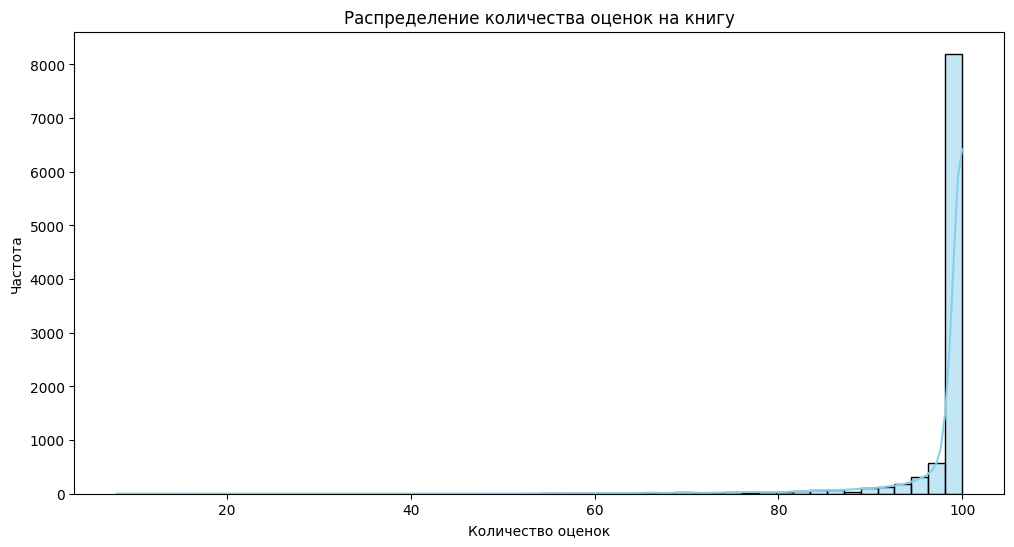

In [40]:
plt.figure(figsize=(12, 6))
sns.histplot(book_stats['n_ratings'], bins=50, kde=True, color='skyblue')
plt.title('Распределение количества оценок на книгу')
plt.xlabel('Количество оценок')
plt.ylabel('Частота')
plt.show()